In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from pathlib import Path

# directory and file paths
data_dir = Path("../data/")
interim_data_dir = data_dir / "interim"
processed_data_dir = data_dir / "processed"

interim_mortgage_file = interim_data_dir / "CountyMortgagesPercent-30-89DaysLate-thru-2020-09.csv"
interim_msa_file = interim_data_dir / "cbsatocountycrosswalk.csv"
processed_covid_file = processed_data_dir / "Monthly_COVID-19_Cases_By_MSA.csv"

In [2]:
mortgage_delinq_df = pd.read_csv(interim_mortgage_file)
mortgage_delinq_df = pd.concat([mortgage_delinq_df.iloc[:,0:4],mortgage_delinq_df.iloc[:,-21:]],axis = 1)
mortgage_delinq_df = mortgage_delinq_df[mortgage_delinq_df['State'].notna()]
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].str.replace("'",'')
mortgage_delinq_df['FIPSCode'] = mortgage_delinq_df['FIPSCode'].astype(int)
mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
1,County,AL,Baldwin County,1003,2.5,2.1,2.0,1.8,2.1,2.6,...,2.5,2.7,1.7,1.7,1.0,1.1,1.1,1.2,0.8,0.8
2,County,AL,Jefferson County,1073,3.6,3.1,2.9,2.5,2.7,2.6,...,3.5,3.7,3.0,2.6,1.8,1.5,1.4,1.3,1.4,1.2
3,County,AL,Lee County,1081,2.8,2.4,2.0,1.7,1.5,1.0,...,2.6,2.7,2.0,2.3,0.9,0.7,0.6,0.6,0.7,0.5
4,County,AL,Madison County,1089,2.2,2.3,2.0,1.7,1.7,1.9,...,2.2,2.2,1.5,1.8,1.0,1.0,0.7,0.8,1.0,0.9
5,County,AL,Mobile County,1097,3.7,3.8,3.8,3.2,3.4,3.2,...,3.8,3.9,3.5,3.6,2.4,1.8,2.0,1.9,1.9,1.6


In [3]:
msa_df = pd.read_csv(interim_msa_file)
msa_df = msa_df.iloc[:,0:9]
msa_df.head()

,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname
0,AUTAUGA,AL,1000,1001,5240.0,NaN,"MONTGOMERY, AL",33860.0,"Montgomery, AL"
1,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN
2,BARBOUR,AL,1020,1005,1.0,NaN,ALABAMA,NaN,NaN
3,BIBB,AL,1030,1007,1.0,NaN,ALABAMA,13820.0,"Birmingham-Hoover, AL"
4,BLOUNT,AL,1040,1009,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL"


In [4]:
mortgage_delinq_df = pd.merge(mortgage_delinq_df, 
                              msa_df, 
                              left_on=['State','FIPSCode'], 
                              right_on = ['state','fipscounty'])

In [5]:
northeast = ["PA", "VT", "ME", "RI", "NY", "CT", "NH", "ME", "NJ", "MA"] 
midwest = ["OH", "IN", "IL", "MI", "WI", "MO", "IA", "MN", "KS", "NE", "SD", "ND"]
west = ["WA", "OR", "CA", "NV", "ID", "MT", "WY", "CO", "NM", "AZ", "UT", "AK", "HI"]
south = ["MD", "DE", "DC", "WV", "VA", "NC", "KY", "TN", "SC", "GA", "FL", "AL", "MS", "AR", "LA", "OK", "TX"]

conditions = [
    (mortgage_delinq_df['State'].isin(northeast)),
    (mortgage_delinq_df['State'].isin(midwest)),
    (mortgage_delinq_df['State'].isin(west)),
    (mortgage_delinq_df['State'].isin(south))
    ]

regions = ['Northeast', 'Midwest', 'West', 'South']

mortgage_delinq_df['Region'] = np.select(conditions, regions)

mortgage_delinq_df.head()

,RegionType,State,Name,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,...,countyname,state,ssacounty,fipscounty,msa,l,msaname,cbsa,cbsaname,Region
0,County,AL,Baldwin County,1003,2.5,2.1,2.0,1.8,2.1,2.6,...,BALDWIN,AL,1010,1003,5160.0,NaN,"MOBILE, AL",NaN,NaN,South
1,County,AL,Jefferson County,1073,3.6,3.1,2.9,2.5,2.7,2.6,...,JEFFERSON,AL,1360,1073,1000.0,NaN,"BIRMINGHAM, AL",13820.0,"Birmingham-Hoover, AL",South
2,County,AL,Lee County,1081,2.8,2.4,2.0,1.7,1.5,1.0,...,LEE,AL,1400,1081,580.0,NaN,"AUBURN-OPELIKA, AL",12220.0,"Auburn-Opelika, AL",South
3,County,AL,Madison County,1089,2.2,2.3,2.0,1.7,1.7,1.9,...,MADISON,AL,1440,1089,3440.0,NaN,"HUNTSVILLE, AL",26620.0,"Huntsville, AL",South
4,County,AL,Mobile County,1097,3.7,3.8,3.8,3.2,3.4,3.2,...,MOBILE,AL,1480,1097,5160.0,NaN,"MOBILE, AL",33660.0,"Mobile, AL",South


In [6]:
mortgage_delinq_df.to_csv(r'mortgage.csv', index = False)

In [19]:
mortgage_df_melted = mortgage_delinq_df.reset_index().melt(id_vars=['Name', "State", "FIPSCode", "Region", "cbsaname"], 
                                                  value_vars=['2019-01','2019-02','2019-03',
                                                              '2019-04','2019-05','2019-06',
                                                              '2019-07','2019-08','2019-09',
                                                              '2019-10','2019-11','2019-12',
                                                              '2020-01','2020-02','2020-03',
                                                              '2020-04','2020-05','2020-06',
                                                              '2020-07','2020-08','2020-09'])
mortgage_df_melted.head()

,Name,State,FIPSCode,Region,cbsaname,variable,value
0,Baldwin County,AL,1003,South,NaN,2019-01,2.5
1,Jefferson County,AL,1073,South,"Birmingham-Hoover, AL",2019-01,3.6
2,Lee County,AL,1081,South,"Auburn-Opelika, AL",2019-01,2.8
3,Madison County,AL,1089,South,"Huntsville, AL",2019-01,2.2
4,Mobile County,AL,1097,South,"Mobile, AL",2019-01,3.7


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

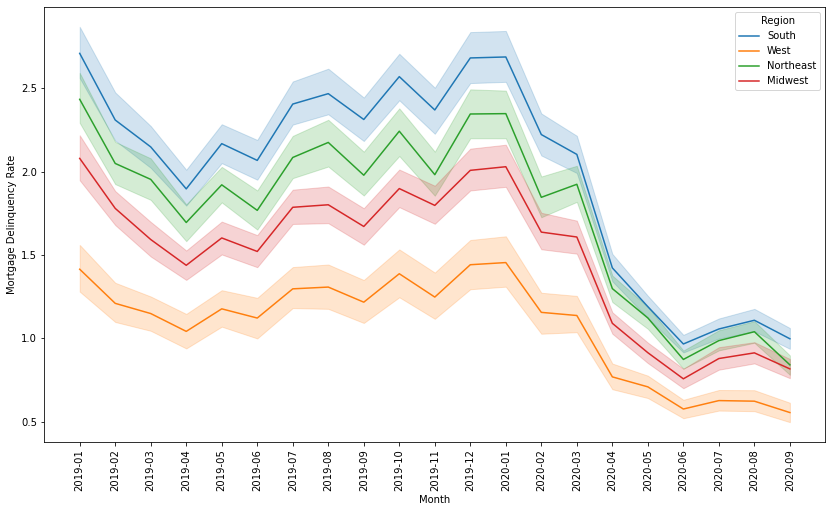

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,8))
ax = sns.lineplot(data=mortgage_df_melted, x="variable", y="value", hue = "Region")
ax.set(xlabel="Month", ylabel = "Mortgage Delinquency Rate")
plt.xticks(rotation=90)

In [9]:
new_df = pd.concat([mortgage_delinq_df.iloc[:,0:25],mortgage_delinq_df['Region']],axis = 1)
new_df_state = new_df.groupby("State").mean()
new_df_state.head()

,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
State,,,,,,,,,,,,,,,,,,,,,
AK,2020.0000,1.500000,1.500000,1.4000,1.300000,1.400000,1.500000,1.800000,1.6000,1.600000,...,1.300000,1.400000,1.600000,1.700000,0.900000,1.100000,0.900000,1.000000,0.900000,0.700000
AL,1085.7500,2.987500,2.725000,2.4750,2.125000,2.287500,2.337500,2.600000,2.8000,2.600000,...,3.075000,3.087500,2.512500,2.487500,1.625000,1.375000,1.125000,1.187500,1.175000,1.075000
AR,5098.5000,2.650000,2.000000,2.1000,1.825000,1.975000,2.050000,2.100000,2.1000,1.800000,...,2.125000,2.400000,2.050000,1.675000,1.325000,1.100000,0.900000,1.000000,1.050000,0.950000
AZ,4020.0000,2.233333,1.883333,1.8000,1.516667,1.650000,1.766667,1.933333,2.1500,1.950000,...,2.183333,2.183333,1.783333,1.800000,1.233333,0.933333,0.783333,0.816667,0.883333,0.833333
CA,6063.4375,1.284375,1.112500,1.1125,1.025000,1.109375,0.950000,1.165625,1.2125,1.115625,...,1.309375,1.343750,1.065625,1.096875,0.753125,0.631250,0.496875,0.546875,0.546875,0.478125


<AxesSubplot:ylabel='State'>

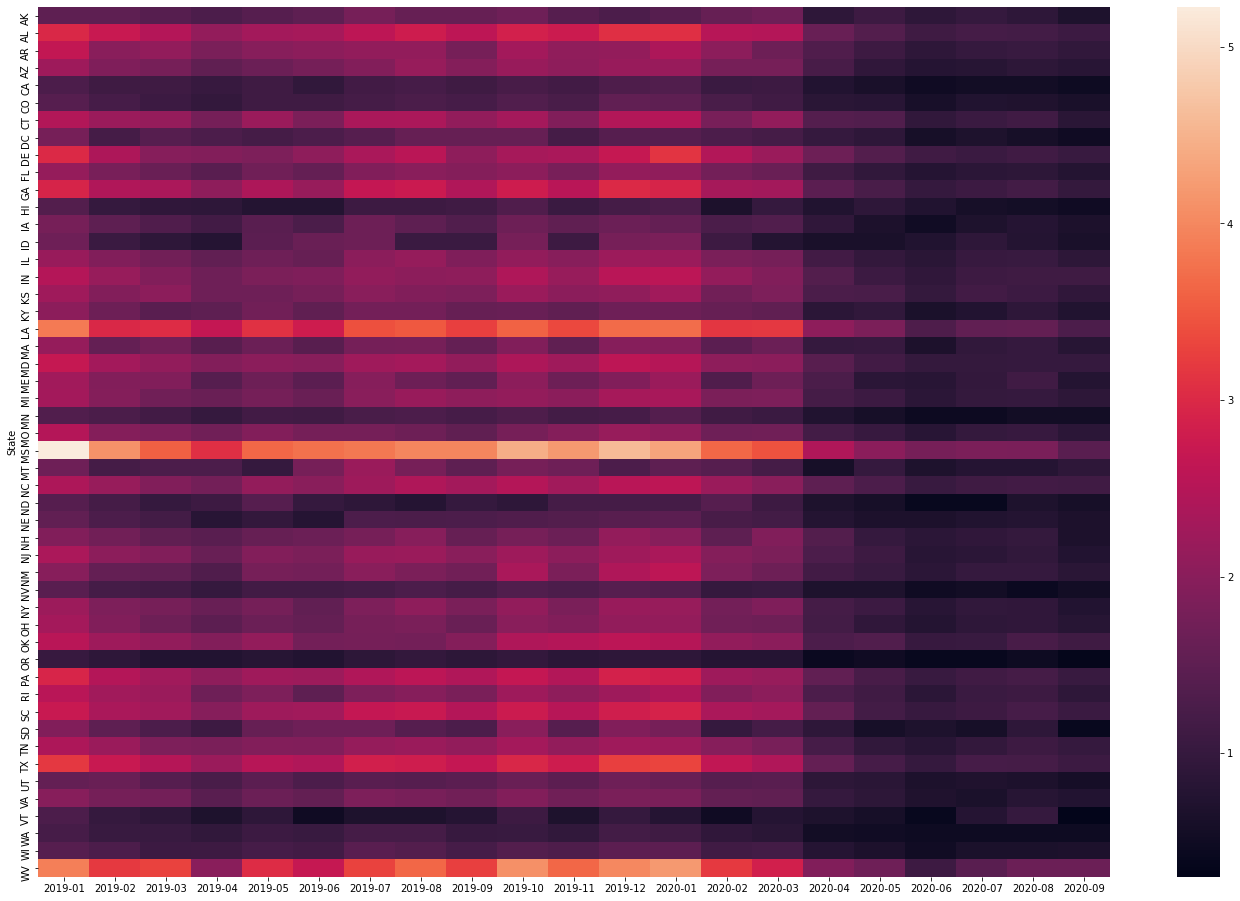

In [11]:
plt.figure(figsize = (24,16))

sns.heatmap(new_df_state.iloc[:,1:23])

In [12]:
new_df_region = new_df.groupby("Region").mean()
new_df_region.head()

,FIPSCode,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,...,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09
Region,,,,,,,,,,,,,,,,,,,,,
Midwest,29388.952830,2.079245,1.779245,1.592453,1.437736,1.601887,1.520755,1.785849,1.800943,1.670755,...,2.007547,2.029245,1.636792,1.607547,1.089623,0.913208,0.756604,0.878302,0.912264,0.816038
Northeast,33636.565217,2.433696,2.048913,1.953261,1.694565,1.920652,1.767391,2.084783,2.175000,1.978261,...,2.345652,2.347826,1.845652,1.923913,1.297826,1.121739,0.872826,0.985870,1.039130,0.840217
South,29912.613757,2.709524,2.309524,2.148148,1.896296,2.167725,2.067196,2.405291,2.467725,2.312698,...,2.682011,2.687831,2.222222,2.103175,1.422222,1.189418,0.965608,1.055556,1.107937,0.996825
West,19988.352941,1.414118,1.209412,1.148235,1.041176,1.176471,1.121176,1.296471,1.307059,1.216471,...,1.441176,1.454118,1.155294,1.136471,0.768235,0.708235,0.575294,0.625882,0.622353,0.554118


<AxesSubplot:ylabel='Region'>

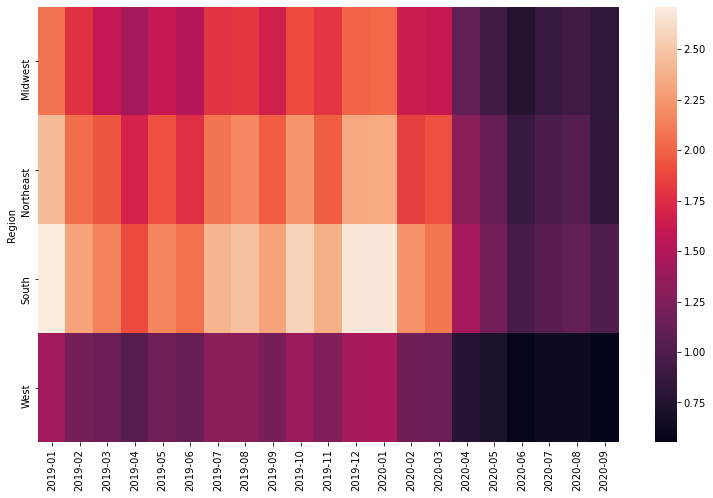

In [13]:
plt.figure(figsize = (13,8))
sns.heatmap(new_df_region.iloc[:,1:23])

In [17]:
monthly_covid = pd.read_csv(processed_covid_file)
monthly_covid.head()

,case_month,cbsa_title,cbsa_code,cases,hosp,icu,deaths,cases_per_capita,population
0,2020-01,"Boise City, ID",14260,61,1,0,0,0.000081,749202.0
1,2020-01,"Boston-Cambridge-Newton, MA-NH",14460,56,2,2,0,0.000011,4873019.0
2,2020-01,"Buffalo-Cheektowaga-Niagara Falls, NY",15380,15,1,0,0,0.000013,1127983.0
3,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0
4,2020-01,"Chicago-Naperville-Elgin, IL-IN-WI",16980,13,0,0,0,0.000001,9458539.0


In [25]:
mortgage_df_melted = mortgage_df_melted.rename(columns={'cbsaname': 'cbsa_title', 'variable': 'case_month', 'value': 'delinq_rate'})
mortgage_df_melted.head()

,Name,State,FIPSCode,Region,cbsa_title,case_month,delinq_rate
0,Baldwin County,AL,1003,South,NaN,2019-01,2.5
1,Jefferson County,AL,1073,South,"Birmingham-Hoover, AL",2019-01,3.6
2,Lee County,AL,1081,South,"Auburn-Opelika, AL",2019-01,2.8
3,Madison County,AL,1089,South,"Huntsville, AL",2019-01,2.2
4,Mobile County,AL,1097,South,"Mobile, AL",2019-01,3.7


In [27]:
MSA_mortgage_case_count = pd.merge(monthly_covid, mortgage_df_melted)
MSA_mortgage_case_count.head()

,case_month,cbsa_title,cbsa_code,cases,hosp,icu,deaths,cases_per_capita,population,Name,State,FIPSCode,Region,delinq_rate
0,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Berkeley County,SC,45015,South,3.7
1,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Charleston County,SC,45019,South,2.0
2,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Dorchester County,SC,45035,South,2.9
3,2020-01,"Columbus, OH",18140,11,0,0,0,0.000005,2122271.0,Delaware County,OH,39041,Midwest,1.1
4,2020-01,"Columbus, OH",18140,11,0,0,0,0.000005,2122271.0,Fairfield County,OH,39045,Midwest,2.0


In [30]:
MSA_mortgage_case_count['delinqs'] = MSA_mortgage_case_count['delinq_rate'] * MSA_mortgage_case_count['population']
MSA_mortgage_case_count.head()

,case_month,cbsa_title,cbsa_code,cases,hosp,icu,deaths,cases_per_capita,population,Name,State,FIPSCode,Region,delinq_rate,delinqs
0,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Berkeley County,SC,45015,South,3.7,2967851.4
1,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Charleston County,SC,45019,South,2.0,1604244.0
2,2020-01,"Charleston-North Charleston, SC",16700,12,0,0,0,0.000015,802122.0,Dorchester County,SC,45035,South,2.9,2326153.8
3,2020-01,"Columbus, OH",18140,11,0,0,0,0.000005,2122271.0,Delaware County,OH,39041,Midwest,1.1,2334498.1
4,2020-01,"Columbus, OH",18140,11,0,0,0,0.000005,2122271.0,Fairfield County,OH,39045,Midwest,2.0,4244542.0


In [34]:
MSA_mortgage_case_count = MSA_mortgage_case_count.groupby(['cbsa_title', 'case_month']).sum()
MSA_mortgage_case_count


cbsa_code  cases  hosp  icu  deaths  cases_per_capita  \
cbsa_title case_month                                                          
Akron, OH  2020-03         20840    614   250   94       0          0.000873   
           2020-04         20840   1434   442  142     200          0.002038   
           2020-05         20840   1316   244   62     100          0.001871   
           2020-06         20840   1158   116   34       0          0.001646   
           2020-07         20840   2620   244   46       0          0.003724   
...                          ...    ...   ...  ...     ...               ...   
Yuma, AZ   2020-05         49740   1570   188    0      32          0.007344   
           2020-06         49740   5494   481    0     123          0.025698   
           2020-07         49740   4097   314    0      72          0.019164   
           2020-08         49740    968    63    0       0          0.004528   
           2020-09         49740    576    28    0       0          0.002694   

                       population  FIPSCode  delinq_rate    delinqs  
cbsa_title case_month                                                
Akron, OH  2020-03      1406958.0     78286          3.3  2321480.7  
           2020-04      1406958.0     78286          2.1  1477305.9  
           2020-05      1406958.0     78286          1.7  1195914.3  
           2020-06      1406958.0     78286          1.7  1195914.3  
           2020-07      1406958.0     78286          1.6  1125566.4  
...                           ...       ...          ...        ...  
Yuma, AZ   2020-05       213787.0      4027          1.7   363437.9  
           2020-06       213787.0      4027          1.5   320680.5  
           2020-07       213787.0      4027          1.4   299301.8  
           2020-08       213787.0      4027          1.7   363437.9  
           2020-09       213787.0      4027          1.5   320680.5  

[1113 rows x 10 columns]

In [35]:
MSA_mortgage_case_count['delinq_rate'] = MSA_mortgage_case_count['delinqs'] / MSA_mortgage_case_count['population']
MSA_mortgage_case_count


cbsa_code  cases  hosp  icu  deaths  cases_per_capita  \
cbsa_title case_month                                                          
Akron, OH  2020-03         20840    614   250   94       0          0.000873   
           2020-04         20840   1434   442  142     200          0.002038   
           2020-05         20840   1316   244   62     100          0.001871   
           2020-06         20840   1158   116   34       0          0.001646   
           2020-07         20840   2620   244   46       0          0.003724   
...                          ...    ...   ...  ...     ...               ...   
Yuma, AZ   2020-05         49740   1570   188    0      32          0.007344   
           2020-06         49740   5494   481    0     123          0.025698   
           2020-07         49740   4097   314    0      72          0.019164   
           2020-08         49740    968    63    0       0          0.004528   
           2020-09         49740    576    28    0       0          0.002694   

                       population  FIPSCode  delinq_rate    delinqs  
cbsa_title case_month                                                
Akron, OH  2020-03      1406958.0     78286         1.65  2321480.7  
           2020-04      1406958.0     78286         1.05  1477305.9  
           2020-05      1406958.0     78286         0.85  1195914.3  
           2020-06      1406958.0     78286         0.85  1195914.3  
           2020-07      1406958.0     78286         0.80  1125566.4  
...                           ...       ...          ...        ...  
Yuma, AZ   2020-05       213787.0      4027         1.70   363437.9  
           2020-06       213787.0      4027         1.50   320680.5  
           2020-07       213787.0      4027         1.40   299301.8  
           2020-08       213787.0      4027         1.70   363437.9  
           2020-09       213787.0      4027         1.50   320680.5  

[1113 rows x 10 columns]

In [36]:
MSA_mortgage_case_count['delinq_rate'].max()

3.9499999999999997

In [37]:
MSA_mortgage_case_count['delinq_rate'].min()

0.1

<AxesSubplot:xlabel='delinq_rate', ylabel='Count'>

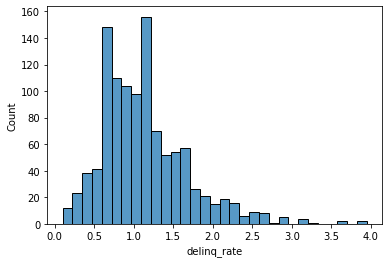

In [38]:
sns.histplot(data=MSA_mortgage_case_count, x="delinq_rate")

In [52]:
MSA_mortgage_case_count['log_delinq_rate'] = np.log(MSA_mortgage_case_count['delinq_rate'])
MSA_mortgage_case_count['deaths_per_capita'] = MSA_mortgage_case_count['deaths']/MSA_mortgage_case_count['population']
MSA_mortgage_case_count['hosp_per_capita'] = MSA_mortgage_case_count['hosp']/MSA_mortgage_case_count['population']
MSA_mortgage_case_count['icu_per_capita'] = MSA_mortgage_case_count['icu']/MSA_mortgage_case_count['population']

MSA_mortgage_case_count

cbsa_code  cases  hosp  icu  deaths  cases_per_capita  \
cbsa_title case_month                                                          
Akron, OH  2020-03         20840    614   250   94       0          0.000873   
           2020-04         20840   1434   442  142     200          0.002038   
           2020-05         20840   1316   244   62     100          0.001871   
           2020-06         20840   1158   116   34       0          0.001646   
           2020-07         20840   2620   244   46       0          0.003724   
...                          ...    ...   ...  ...     ...               ...   
Yuma, AZ   2020-05         49740   1570   188    0      32          0.007344   
           2020-06         49740   5494   481    0     123          0.025698   
           2020-07         49740   4097   314    0      72          0.019164   
           2020-08         49740    968    63    0       0          0.004528   
           2020-09         49740    576    28    0       0          0.002694   

                       population  FIPSCode  delinq_rate    delinqs  \
cbsa_title case_month                                                 
Akron, OH  2020-03      1406958.0     78286         1.65  2321480.7   
           2020-04      1406958.0     78286         1.05  1477305.9   
           2020-05      1406958.0     78286         0.85  1195914.3   
           2020-06      1406958.0     78286         0.85  1195914.3   
           2020-07      1406958.0     78286         0.80  1125566.4   
...                           ...       ...          ...        ...   
Yuma, AZ   2020-05       213787.0      4027         1.70   363437.9   
           2020-06       213787.0      4027         1.50   320680.5   
           2020-07       213787.0      4027         1.40   299301.8   
           2020-08       213787.0      4027         1.70   363437.9   
           2020-09       213787.0      4027         1.50   320680.5   

                       log_delinq_rate  deaths_per_capita  hosp_per_capita  \
cbsa_title case_month                                                        
Akron, OH  2020-03            0.500775           0.000000         0.000178   
           2020-04            0.048790           0.000142         0.000314   
           2020-05           -0.162519           0.000071         0.000173   
           2020-06           -0.162519           0.000000         0.000082   
           2020-07           -0.223144           0.000000         0.000173   
...                                ...                ...              ...   
Yuma, AZ   2020-05            0.530628           0.000150         0.000879   
           2020-06            0.405465           0.000575         0.002250   
           2020-07            0.336472           0.000337         0.001469   
           2020-08            0.530628           0.000000         0.000295   
           2020-09            0.405465           0.000000         0.000131   

                       icu_per_capita  
cbsa_title case_month                  
Akron, OH  2020-03           0.000067  
           2020-04           0.000101  
           2020-05           0.000044  
           2020-06           0.000024  
           2020-07           0.000033  
...                               ...  
Yuma, AZ   2020-05           0.000000  
           2020-06           0.000000  
           2020-07           0.000000  
           2020-08           0.000000  
           2020-09           0.000000  

[1098 rows x 14 columns]

<AxesSubplot:xlabel='log_delinq_rate', ylabel='Count'>

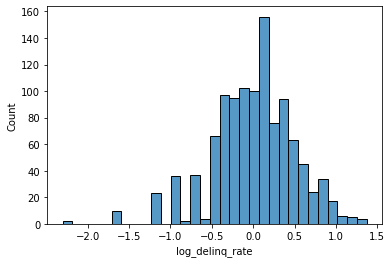

In [42]:
sns.histplot(data=MSA_mortgage_case_count, x="log_delinq_rate")

In [48]:
from sklearn.linear_model import LinearRegression

MSA_mortgage_case_count = MSA_mortgage_case_count[MSA_mortgage_case_count['cases_per_capita'].notna()]
MSA_mortgage_case_count = MSA_mortgage_case_count[MSA_mortgage_case_count['log_delinq_rate'].notna()]

x = np.array(MSA_mortgage_case_count['cases_per_capita']).reshape((-1, 1))
y = np.array(MSA_mortgage_case_count['log_delinq_rate'])

model = LinearRegression().fit(x, y)

In [49]:
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.016601534766379822


In [56]:
import statsmodels.api as sm

x = MSA_mortgage_case_count['cases_per_capita']
y = MSA_mortgage_case_count['log_delinq_rate']

mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        log_delinq_rate   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              10.78
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                     0.00106
Time:                        19:34:38   Log-Likelihood:                         -800.18
No. Observations:                1098   AIC:                                      1602.
Df Residuals:                    1097   BIC:                                      1607.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [57]:
import statsmodels.api as sm

x = MSA_mortgage_case_count['deaths_per_capita']
y = MSA_mortgage_case_count['log_delinq_rate']

mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        log_delinq_rate   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              2.403
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                       0.121
Time:                        19:34:53   Log-Likelihood:                         -804.34
No. Observations:                1098   AIC:                                      1611.
Df Residuals:                    1097   BIC:                                      1616.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [58]:
import statsmodels.api as sm

x = MSA_mortgage_case_count['icu_per_capita']
y = MSA_mortgage_case_count['log_delinq_rate']

mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        log_delinq_rate   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.285
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                       0.257
Time:                        19:36:03   Log-Likelihood:                         -804.90
No. Observations:                1098   AIC:                                      1612.
Df Residuals:                    1097   BIC:                                      1617.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [61]:
import statsmodels.api as sm

x = MSA_mortgage_case_count['hosp_per_capita']
y = MSA_mortgage_case_count['log_delinq_rate']

mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:        log_delinq_rate   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.001
Method:                 Least Squares   F-statistic:                            0.01571
Date:                Sat, 24 Apr 2021   Prob (F-statistic):                       0.900
Time:                        19:37:47   Log-Likelihood:                         -805.54
No. Observations:                1098   AIC:                                      1613.
Df Residuals:                    1097   BIC:                                      1618.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

In [60]:
X = MSA_mortgage_case_count[['cases_per_capita', 
                             'deaths_per_capita', 
                             'icu_per_capita', 
                             'hosp_per_capita']] 
y = MSA_mortgage_case_count['log_delinq_rate']
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:        log_delinq_rate   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.157
Date:                Sat, 24 Apr 2021   Prob (F-statistic):           1.09e-05
Time:                        19:37:22   Log-Likelihood:                -791.33
No. Observations:                1098   AIC:                             1593.
Df Residuals:                    1093   BIC:                             1618.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0461      0.02